# Hypothesis testing of regression coefficients

Perform a regression repeatedly on different random samples from the NHTS.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from mpl_toolkits import mplot3d
from io import StringIO

In [2]:
hh17 = pd.read_csv('../data/hhpub.csv')
veh17 = pd.read_csv('../data/vehpub.csv')

In [3]:
veh17.loc[veh17.ANNMILES < 0, 'ANNMILES'] = np.nan

In [4]:
vmt = veh17.groupby('HOUSEID', as_index=False).ANNMILES.sum()

In [5]:
hh17 = hh17.merge(vmt, on='HOUSEID', how='left', validate='1:1')

In [6]:
hh17['income_midpoint'] = hh17.HHFAMINC.map({
    -7: np.nan,
    -8: np.nan,
    -9: np.nan,
    1: 5000,
    2: 12500,
    3: 20000,
    4: 30000,
    5: 42500,
    6: 62500,
    7: 87500,
    8: 112500,
    9: 137500,
    10: 175000,
    11: 225000
})

In [7]:
hh17 = hh17.dropna(subset=['ANNMILES', 'income_midpoint'])

In [8]:
np.random.seed(7482)
hh17['income'] = (hh17.income_midpoint + np.random.uniform(-5000, 5000, len(hh17))) / 1000

In [9]:
hh17.to_csv('../data/hh17_modified.csv')

## Plot a single regression for use in the paper

In [10]:
# 242
regdat = hh17.sample(250, random_state=121)


In [11]:
mod = sm.OLS(regdat.ANNMILES, sm.add_constant(regdat[['income']]))
fit = mod.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ANNMILES   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     33.51
Date:                Thu, 27 Aug 2020   Prob (F-statistic):           2.14e-08
Time:                        14:32:52   Log-Likelihood:                -2764.3
No. Observations:                 250   AIC:                             5533.
Df Residuals:                     248   BIC:                             5540.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6904.8496   1659.260      4.161      0.000    3636.812    1.02e+04
income        99.2877     17.153      5.788      0.000      65.504     133.071
==============================================================================
Omnibus:                      215.114   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5717.338
Skew:                           3.199   Prob(JB):                         0.00
Kurtosis:                      25.537   Cond. No.                         165.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

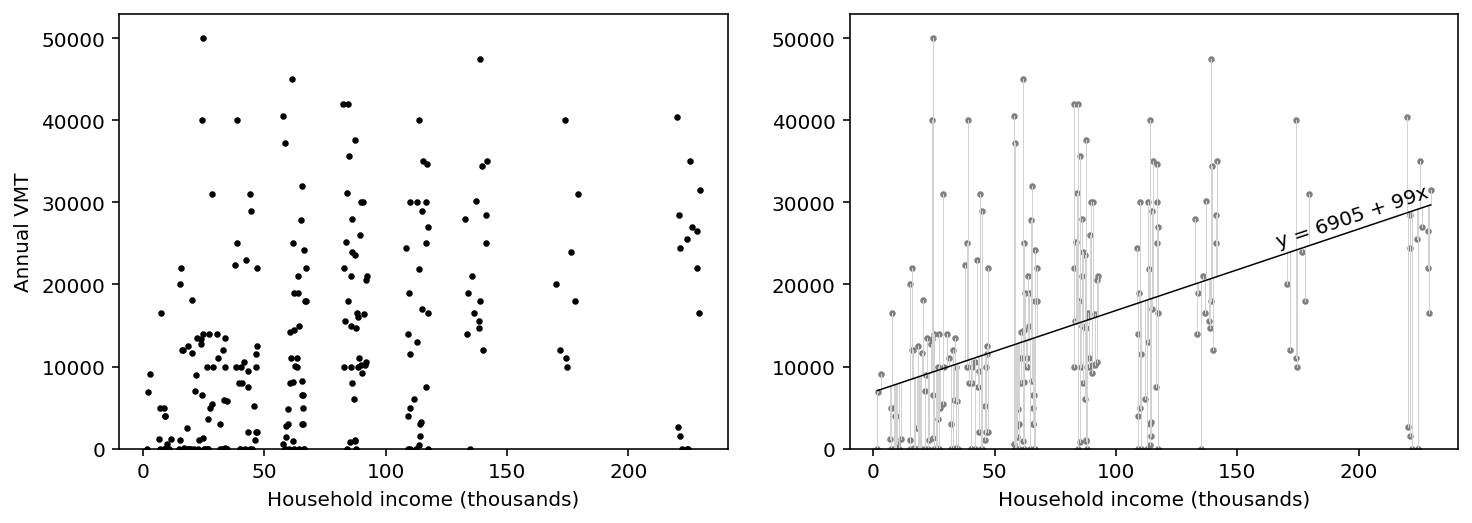

In [12]:
plt.subplots(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(regdat.income, regdat.ANNMILES, color='black', s=5)
plt.ylim(0, 53000)
plt.xlabel('Household income (thousands)')
plt.ylabel('Annual VMT')

# plot residuals on bottom
ax = plt.subplot(1, 2, 2)
for i in range(len(regdat)):
    # don't draw ones off screen
    if regdat.ANNMILES.iloc[i] < 53000:
        plt.plot([regdat.income.iloc[i], regdat.income.iloc[i]], [regdat.ANNMILES.iloc[i], fit.fittedvalues.iloc[i]], color='lightgray', lw=0.5)
    
plt.ylim(0, 53000)

minLoc = regdat.income.idxmin()
maxLoc = regdat.income.idxmax()

plt.plot(regdat.income.loc[[minLoc, maxLoc]], fit.fittedvalues.loc[[minLoc, maxLoc]],
         color='black', lw=0.75)

plt.scatter(regdat.income, regdat.ANNMILES, color='gray', s=5)

# https://scipython.com/blog/rotating-text-onto-a-line-in-matplotlib/
#https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/text_rotation_relative_to_line.html#sphx-glr-gallery-text-labels-and-annotations-text-rotation-relative-to-line-py
p1 = ax.transData.transform_point((regdat.income.loc[minLoc], fit.fittedvalues.loc[minLoc]))
p2 = ax.transData.transform_point((regdat.income.loc[maxLoc], fit.fittedvalues.loc[maxLoc]))
dy = (p2[1] - p1[1])
dx = (p2[0] - p1[0])
rotn = np.degrees(np.arctan2(dy, dx))
plt.text(regdat.income.loc[maxLoc], fit.fittedvalues.loc[maxLoc] + 500, f'y = {fit.params.const:.0f} + {fit.params.income:.0f}x',
         rotation=rotn, va='bottom', ha='right', rotation_mode='anchor')

plt.xlabel('Household income (thousands)')
plt.savefig('../fig/bivariateregression.pdf')

In [13]:
def formatModel (fit):
    out = StringIO()
    
    # now make the table of coefficients
    coefs = pd.DataFrame({
        'Coefficient': fit.params,
        'Std. err.': fit.bse,
        '$t$-value': fit.tvalues,
        '$p$-value': fit.pvalues,
        '95% Conf.': fit.conf_int()[0],
        'Int.': fit.conf_int()[1]
    }).round(3)
    
    coefs['Coefficient'] = coefs.Coefficient.round(0).astype('int64')
    coefs['Std. err.'] = coefs['Std. err.'].round(0).astype('int64')
    coefs['95% Conf.'] = coefs['95% Conf.'].round(0).astype('int64')
    coefs['Int.'] = coefs['Int.'].round(0).astype('int64')

    
    coefs.rename(index={
        'const': 'Constant',
        'income': 'Income (thousands)',
        'HHVEHCNT': 'Number of vehicles',
        'TRAVDAY': 'Day of week',
        'region_Midwest': 'Region: Midwest',
        'region_South': 'Region: South',
        'region_West': 'Region: West',
        'income_west': 'Income (West)',
        'income_south': 'Income (South)',
        'income_midwest': 'Income (Midwest)',
        'popdenk': 'Population density (thousands per sq. mi.)',
        'income*popdenk': 'Interaction of income and population density',
    }).to_latex(out)
    
    out.write('\\begin{tabular}{lclc}\n')
    out.write('Dependent variable & \\multicolumn{3}{l}{Annual vehicle miles traveled} \\\\\n')
    out.write(f'$R^2$ & {fit.rsquared:.2f} & Adjusted $R^2$ & {fit.rsquared_adj:.2f} \\\\\n')
    out.write(f'Sample size & {int(fit.nobs)} && \\\\\n')
    out.write('\\end{tabular}\n')
        
    return out.getvalue().replace('\\$', '$')

In [14]:
print(formatModel(fit))

\begin{tabular}{lrrrrrr}
\toprule
{} &  Coefficient &  Std. err. &  $t$-value &  $p$-value &  95\% Conf. &   Int. \\
\midrule
Constant           &         6905 &       1659 &      4.161 &        0.0 &       3637 &  10173 \\
Income (thousands) &           99 &         17 &      5.788 &        0.0 &         66 &    133 \\
\bottomrule
\end{tabular}
\begin{tabular}{lclc}
Dependent variable & \multicolumn{3}{l}{Annual vehicle miles traveled} \\
$R^2$ & 0.12 & Adjusted $R^2$ & 0.12 \\
Sample size & 250 && \\
\end{tabular}



In [15]:
mod3d = sm.OLS(regdat.ANNMILES, sm.add_constant(regdat[['income', 'HHVEHCNT']]))
fit3d = mod3d.fit()
fit3d.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ANNMILES   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     29.09
Date:                Thu, 27 Aug 2020   Prob (F-statistic):           4.52e-12
Time:                        14:32:55   Log-Likelihood:                -2753.7
No. Observations:                 250   AIC:                             5513.
Df Residuals:                     247   BIC:                             5524.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -95.5351   2186.724     -0.044      0.965   -4402.538    4211.468
income        78.1576     17.083      4.575      0.000      44.511     111.804
HHVEHCNT    4242.7498    907.531      4.675      0.000    2455.263    6030.236
==============================================================================
Omnibus:                      207.675   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5113.957
Skew:                           3.059   Prob(JB):                         0.00
Kurtosis:                      24.296   Cond. No.                         236.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

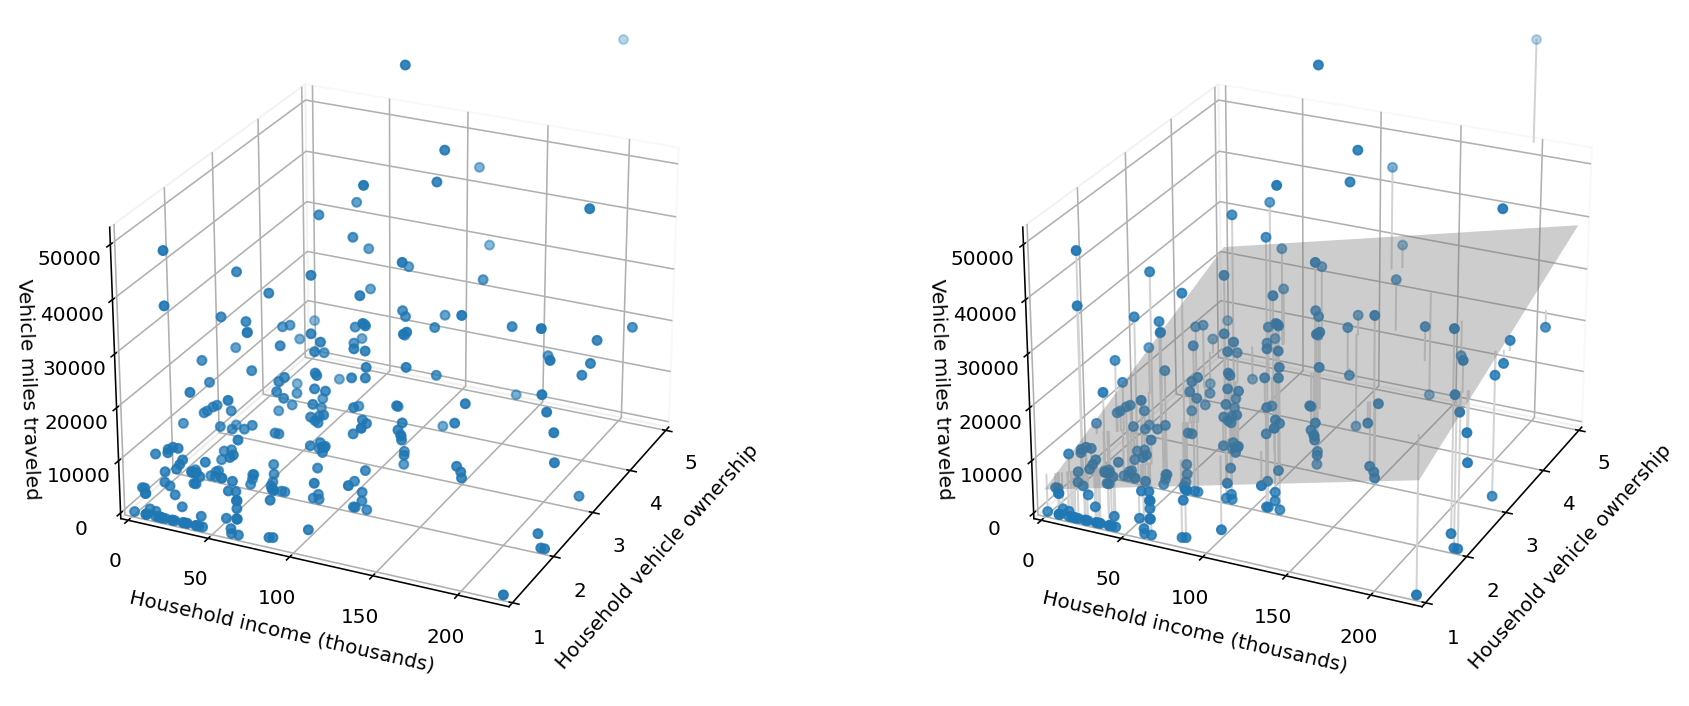

In [16]:
plt.subplots(figsize=(15, 6))

ax = plt.subplot(1, 2, 1, projection='3d')
ax.view_init(25, 25)
ax.scatter3D(regdat.HHVEHCNT, regdat.income, regdat.ANNMILES)
ax.set_zlim(0, 52000)
ax.set_xlim(5, 1)
ax.set_ylim(0, 225)

ax.set_xlabel('    Household vehicle ownership')
ax.set_ylabel('Household income (thousands)')
ax.set_zlabel('Vehicle miles traveled')
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_yticks([0, 50, 100, 150, 200])

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
        

ax = plt.subplot(1, 2, 2, projection='3d')
ax.view_init(25, 25)
ax.scatter3D(regdat.HHVEHCNT, regdat.income, regdat.ANNMILES)
ax.set_zlim(0, 52000)
ax.set_xlim(5, 1)
ax.set_ylim(0, 225)
ax.plot_surface(
    [[1, 5], [1, 5]],
    [[0, 0], [225, 225]],
    fit3d.predict(pd.DataFrame(dict(
        const=[1, 1, 1, 1],
        income=[0, 225, 0, 225],
        HHVEHCNT=[1, 1, 5, 5]
    ))).values.reshape((2, 2)),
    alpha=0.35,
    color='gray'
)
ax.set_xlabel('    Household vehicle ownership')
ax.set_ylabel('Household income (thousands)')
ax.set_zlabel('Vehicle miles traveled')
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_yticks([0, 50, 100, 150, 200])


for i in range(len(regdat)):
    if regdat.ANNMILES.iloc[i] < 53000:
        plt.plot(
            [regdat.HHVEHCNT.iloc[i], regdat.HHVEHCNT.iloc[i]],
            [regdat.income.iloc[i], regdat.income.iloc[i]],
            [regdat.ANNMILES.iloc[i], fit.fittedvalues.iloc[i]], color='lightgray', lw=1)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
        
plt.savefig('../fig/trivariateregression.pdf')

In [17]:
print(formatModel(fit3d))

\begin{tabular}{lrrrrrr}
\toprule
{} &  Coefficient &  Std. err. &  $t$-value &  $p$-value &  95\% Conf. &  Int. \\
\midrule
Constant           &          -96 &       2187 &     -0.044 &      0.965 &      -4403 &  4211 \\
Income (thousands) &           78 &         17 &      4.575 &      0.000 &         45 &   112 \\
Number of vehicles &         4243 &        908 &      4.675 &      0.000 &       2455 &  6030 \\
\bottomrule
\end{tabular}
\begin{tabular}{lclc}
Dependent variable & \multicolumn{3}{l}{Annual vehicle miles traveled} \\
$R^2$ & 0.19 & Adjusted $R^2$ & 0.18 \\
Sample size & 250 && \\
\end{tabular}



## Travel day

Add the travel day variable to the regression, to demonstrate that a coefficient will be estimated even for an insignificant variable.

In [18]:
modtd = sm.OLS(regdat.ANNMILES, sm.add_constant(regdat[['income', 'HHVEHCNT', 'TRAVDAY']]))
fittd = modtd.fit()
fittd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ANNMILES   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     19.43
Date:                Thu, 27 Aug 2020   Prob (F-statistic):           2.44e-11
Time:                        14:32:58   Log-Likelihood:                -2753.5
No. Observations:                 250   AIC:                             5515.
Df Residuals:                     246   BIC:                             5529.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1253.2140   3090.678     -0.405      0.685   -7340.781    4834.353
income        78.7154     17.140      4.593      0.000      44.956     112.475
HHVEHCNT    4248.6852    908.922      4.674      0.000    2458.423    6038.948
TRAVDAY      272.4736    513.315      0.531      0.596    -738.580    1283.527
==============================================================================
Omnibus:                      209.232   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5279.697
Skew:                           3.084   Prob(JB):                         0.00
Kurtosis:                      24.652   Cond. No.                         325.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
print(formatModel(fittd))

\begin{tabular}{lrrrrrr}
\toprule
{} &  Coefficient &  Std. err. &  $t$-value &  $p$-value &  95\% Conf. &  Int. \\
\midrule
Constant           &        -1253 &       3091 &     -0.405 &      0.685 &      -7341 &  4834 \\
Income (thousands) &           79 &         17 &      4.593 &      0.000 &         45 &   112 \\
Number of vehicles &         4249 &        909 &      4.674 &      0.000 &       2458 &  6039 \\
Day of week        &          272 &        513 &      0.531 &      0.596 &       -739 &  1284 \\
\bottomrule
\end{tabular}
\begin{tabular}{lclc}
Dependent variable & \multicolumn{3}{l}{Annual vehicle miles traveled} \\
$R^2$ & 0.19 & Adjusted $R^2$ & 0.18 \\
Sample size & 250 && \\
\end{tabular}



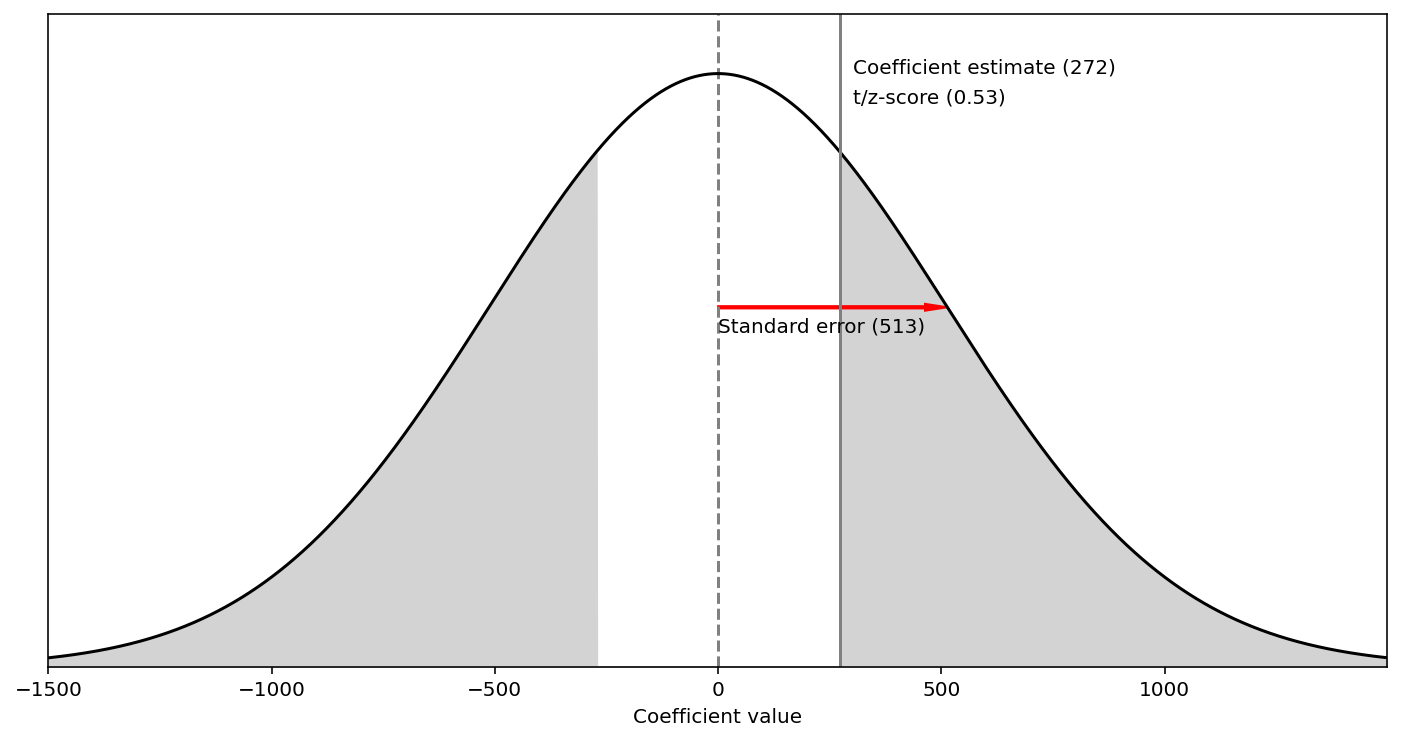

In [20]:
x = np.arange(-1500, 1500, 1)
y = scipy.stats.t.pdf(x, 246, 0, fittd.bse.TRAVDAY)

plt.subplots(figsize=(12,6))
plt.yticks([])
plt.xlabel('Coefficient value')
plt.axvline(0, ls='--', color='gray')
plt.plot(x, y, color='black')
plt.axvline(fittd.params.TRAVDAY, color='gray')
plt.ylim([0, y.max() * 1.1])
plt.xlim([x.min(), x.max()])
plt.fill_between(x, np.zeros_like(y), np.choose(np.abs(x) >= np.abs(fittd.params.TRAVDAY), [np.zeros_like(y), y]), color='lightgray')
plt.text(fittd.params.TRAVDAY + 30, y.max(), f'Coefficient estimate ({fittd.params.TRAVDAY:.0f})')
plt.savefig('../fig/coeftest.pdf')
onesdy = scipy.stats.t.pdf(fittd.bse.TRAVDAY, 246, 0, fittd.bse.TRAVDAY)
plt.arrow(0, onesdy, fittd.bse.TRAVDAY, 0, width=3e-6, head_length=50, length_includes_head=True, color='red')
plt.text(0, onesdy * 0.93, f'Standard error ({fittd.bse.TRAVDAY:.0f})')
plt.savefig('../fig/coeftest_se.pdf')
plt.text(fittd.params.TRAVDAY + 30, y.max() * 0.95, f't/z-score ({fittd.tvalues.TRAVDAY:.2f})')
plt.savefig('../fig/coeftest_t.pdf')

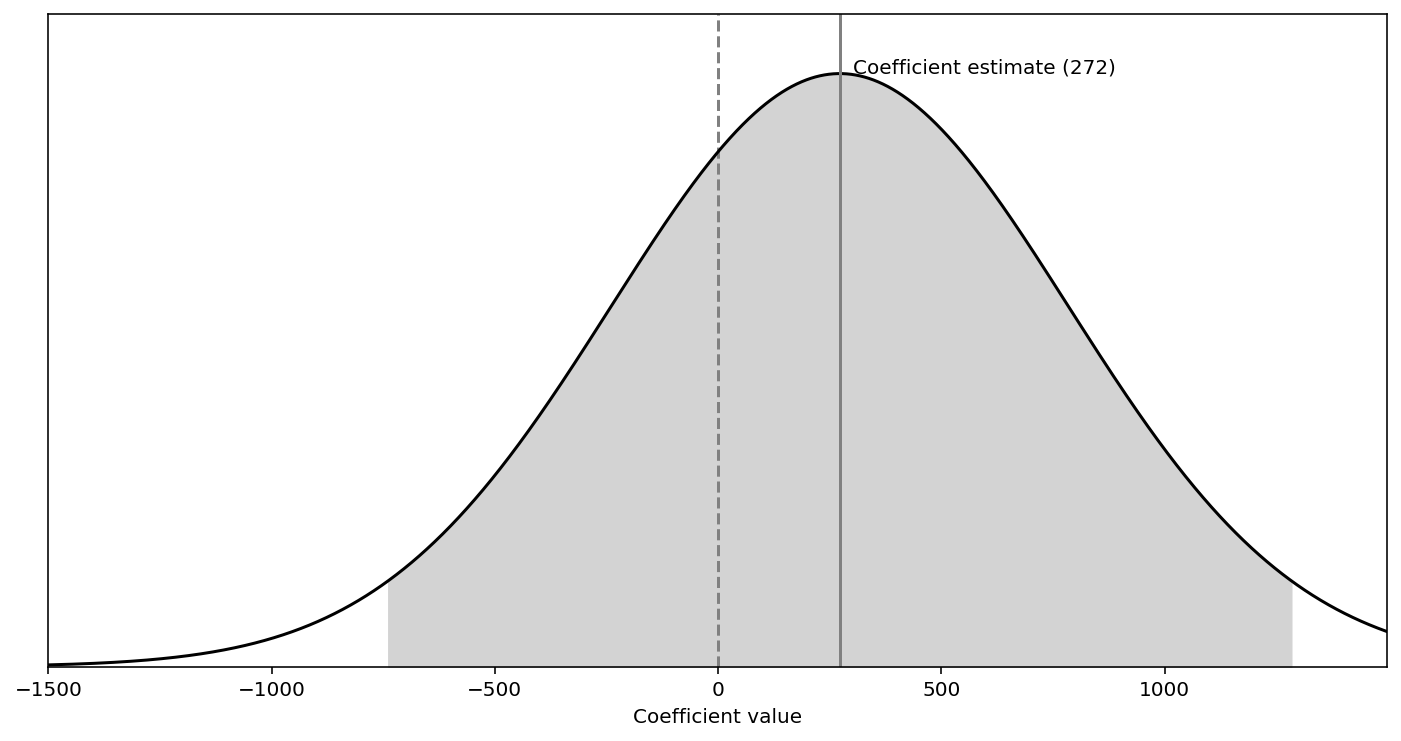

In [21]:
x = np.arange(-1500, 1500, 1)
y = scipy.stats.t.pdf(x, 246, fittd.params.TRAVDAY, fittd.bse.TRAVDAY)

plt.subplots(figsize=(12,6))

plt.yticks([])
plt.xlabel('Coefficient value')
plt.axvline(0, ls='--', color='gray')
plt.plot(x, y, color='black')
plt.axvline(fittd.params.TRAVDAY, color='gray')
plt.ylim([0, y.max() * 1.1])
plt.xlim([x.min(), x.max()])
#plt.fill_between(x, np.zeros_like(y), np.choose(np.abs(x) >= np.abs(fittd.params.TRAVDAY), [np.zeros_like(y), y]), color='lightgray')

plt.text(fittd.params.TRAVDAY + 30, y.max(), f'Coefficient estimate ({fittd.params.TRAVDAY:.0f})')
plt.savefig('../fig/confint.pdf')

low = scipy.stats.t.ppf(0.025, 246, fittd.params.TRAVDAY, fittd.bse.TRAVDAY)
high = scipy.stats.t.ppf(0.975, 246, fittd.params.TRAVDAY, fittd.bse.TRAVDAY)
plt.fill_between(x[(x >= low) & (x <= high)], y[(x >= low) & (x <= high)], color='lightgray')
plt.savefig('../fig/confint_filled.pdf')

In [22]:
regdat['region'] = regdat.CENSUS_R.map({
    1: 'Northeast',
    2: 'Midwest',
    3: 'South',
    4: 'West'
})

assert not regdat.region.isnull().any()

In [23]:
modr = sm.OLS(regdat.ANNMILES, sm.add_constant(pd.get_dummies(regdat[['income', 'HHVEHCNT', 'region']])).drop(columns=['region_Northeast']))
fitr = modr.fit()
fitr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ANNMILES   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     14.20
Date:                Thu, 27 Aug 2020   Prob (F-statistic):           3.37e-12
Time:                        14:33:00   Log-Likelihood:                -2748.2
No. Observations:                 250   AIC:                             5508.
Df Residuals:                     244   BIC:                             5529.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -3101.0117   3109.369     -0.997      0.320   -9225.642    3023.619
income            86.0682     17.225      4.997      0.000      52.139     119.997
HHVEHCNT        4339.5460    899.911      4.822      0.000    2566.961    6112.131
region_Midwest  1267.5403   3586.251      0.353      0.724   -5796.421    8331.502
region_South    5228.9502   2865.374      1.825      0.069    -415.075    1.09e+04
region_West    -1959.5193   3163.414     -0.619      0.536   -8190.604    4271.566
==============================================================================
Omnibus:                      201.243   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4845.475
Skew:                           2.921   Prob(JB):                         0.00
Kurtosis:                      23.761   Cond. No.                         566.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
print(formatModel(fitr))

\begin{tabular}{lrrrrrr}
\toprule
{} &  Coefficient &  Std. err. &  $t$-value &  $p$-value &  95\% Conf. &   Int. \\
\midrule
Constant           &        -3101 &       3109 &     -0.997 &      0.320 &      -9226 &   3024 \\
Income (thousands) &           86 &         17 &      4.997 &      0.000 &         52 &    120 \\
Number of vehicles &         4340 &        900 &      4.822 &      0.000 &       2567 &   6112 \\
Region: Midwest    &         1268 &       3586 &      0.353 &      0.724 &      -5796 &   8332 \\
Region: South      &         5229 &       2865 &      1.825 &      0.069 &       -415 &  10873 \\
Region: West       &        -1960 &       3163 &     -0.619 &      0.536 &      -8191 &   4272 \\
\bottomrule
\end{tabular}
\begin{tabular}{lclc}
Dependent variable & \multicolumn{3}{l}{Annual vehicle miles traveled} \\
$R^2$ & 0.23 & Adjusted $R^2$ & 0.21 \\
Sample size & 250 && \\
\end{tabular}



In [25]:
intdata = pd.get_dummies(regdat[['income', 'HHVEHCNT', 'region']]).drop(columns=['region_Northeast'])
intdata['income_west'] = intdata.region_West * intdata.income
intdata['income_south'] = intdata.region_South * intdata.income
intdata['income_midwest'] = intdata.region_Midwest * intdata.income

modint = sm.OLS(regdat.ANNMILES, sm.add_constant(intdata))
fitint = modint.fit()
fitint.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ANNMILES   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     9.276
Date:                Thu, 27 Aug 2020   Prob (F-statistic):           3.89e-11
Time:                        14:33:01   Log-Likelihood:                -2746.5
No. Observations:                 250   AIC:                             5511.
Df Residuals:                     241   BIC:                             5543.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2290.9044   4649.244     -0.493      0.623   -1.14e+04    6867.438
income            73.9713     49.842      1.484      0.139     -24.210     172.152
HHVEHCNT        4392.6205    902.523      4.867      0.000    2614.780    6170.461
region_Midwest -4597.8590   6167.084     -0.746      0.457   -1.67e+04    7550.409
region_South    3936.5722   5018.731      0.784      0.434   -5949.606    1.38e+04
region_West     -235.2199   5643.974     -0.042      0.967   -1.14e+04    1.09e+04
income_west      -14.6284     57.277     -0.255      0.799    -127.456      98.200
income_south      17.2930     55.292      0.313      0.755     -91.625     126.211
income_midwest    90.9867     72.871      1.249      0.213     -52.559     234.532
==============================================================================
Omnibus:                      202.555   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5019.726
Skew:                           2.938   Prob(JB):                         0.00
Kurtosis:                      24.151   Cond. No.                     1.15e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
print(formatModel(fitint))

\begin{tabular}{lrrrrrr}
\toprule
{} &  Coefficient &  Std. err. &  $t$-value &  $p$-value &  95\% Conf. &   Int. \\
\midrule
Constant           &        -2291 &       4649 &     -0.493 &      0.623 &     -11449 &   6867 \\
Income (thousands) &           74 &         50 &      1.484 &      0.139 &        -24 &    172 \\
Number of vehicles &         4393 &        903 &      4.867 &      0.000 &       2615 &   6170 \\
Region: Midwest    &        -4598 &       6167 &     -0.746 &      0.457 &     -16746 &   7550 \\
Region: South      &         3937 &       5019 &      0.784 &      0.434 &      -5950 &  13823 \\
Region: West       &         -235 &       5644 &     -0.042 &      0.967 &     -11353 &  10883 \\
Income (West)      &          -15 &         57 &     -0.255 &      0.799 &       -127 &     98 \\
Income (South)     &           17 &         55 &      0.313 &      0.755 &        -92 &    126 \\
Income (Midwest)   &           91 &         73 &      1.249 &      0.213 &        -53 &   

## Plot of the logarithm

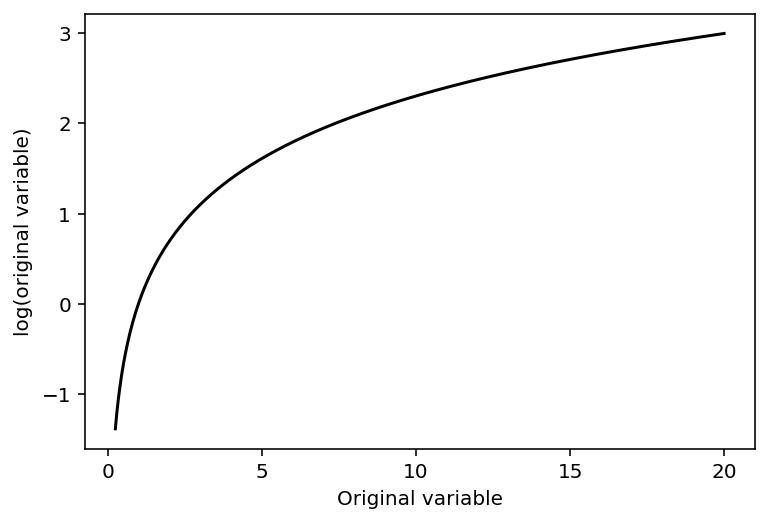

In [27]:
x = np.arange(0.25, 20, 0.01)
y = np.log(x)
plt.plot(x, y, color='black')
plt.xticks(np.arange(0, 21, 5))
plt.xlabel('Original variable')
plt.ylabel('log(original variable)')
plt.savefig('../fig/log.pdf')

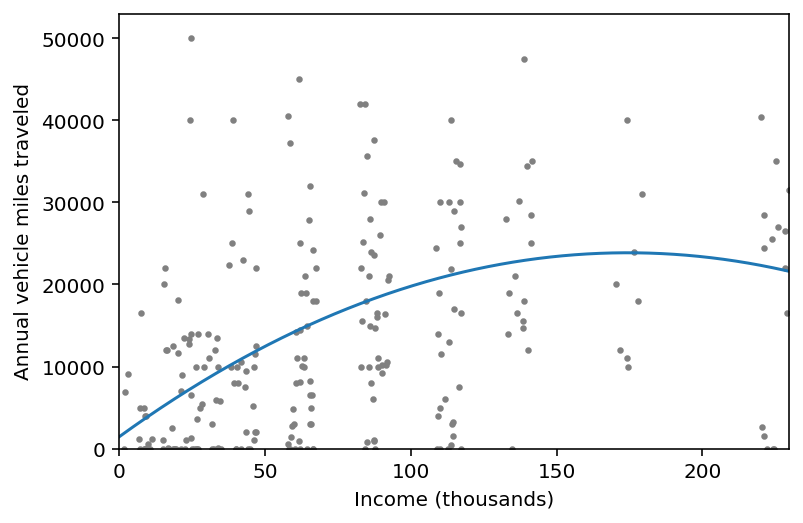

In [28]:
powdat = regdat[['income']].copy()
for i in range(2, 3):
    powdat[f'income^{i}'] = np.power(regdat.income, i)
    
powmod = sm.OLS(regdat.ANNMILES, sm.add_constant(powdat))
powfit = powmod.fit()
powfit.summary()

pdat = pd.DataFrame({'income': np.arange(0, 300, 0.25)})
for i in range(2, 3):
    pdat[f'income^{i}'] = np.power(pdat.income, i)
    
pdat['fitted'] = powfit.predict(sm.add_constant(pdat))

plt.scatter(regdat.income, regdat.ANNMILES, color='gray', s=5)
plt.plot(pdat.income, pdat.fitted)
plt.ylim(0, 53000)
plt.xlim([0, regdat.income.max()])
plt.xlabel('Income (thousands)')
plt.ylabel('Annual vehicle miles traveled')
plt.savefig('../fig/power2.pdf')

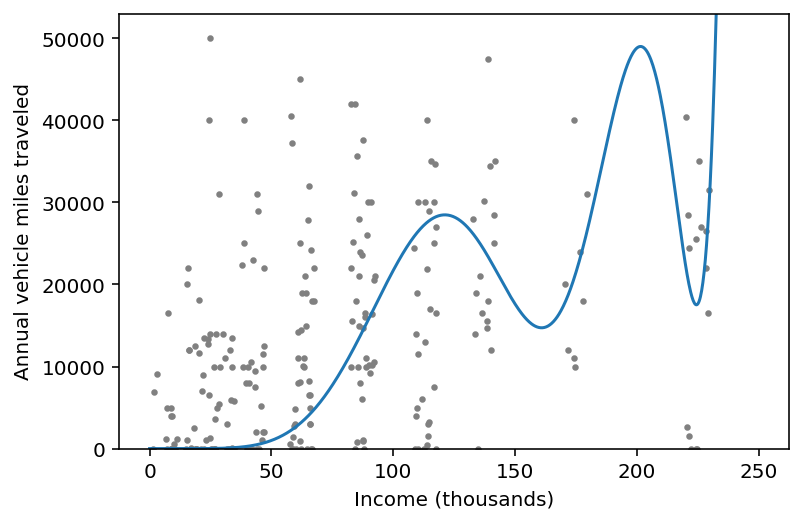

In [29]:
powdat = regdat[['income']].copy()
for i in range(2, 12):
    powdat[f'income^{i}'] = np.power(regdat.income, i)
    
powmod = sm.OLS(regdat.ANNMILES, sm.add_constant(powdat))
powfit = powmod.fit()
powfit.summary()

pdat = pd.DataFrame({'income': np.arange(0, 250, 0.25)})
for i in range(2, 12):
    pdat[f'income^{i}'] = np.power(pdat.income, i)
    
pdat['fitted'] = powfit.predict(sm.add_constant(pdat))

plt.scatter(regdat.income, regdat.ANNMILES, color='gray', s=5)
plt.plot(pdat.income, pdat.fitted)
plt.ylim(0, 53000)
plt.xlabel('Income (thousands)')
plt.ylabel('Annual vehicle miles traveled')
plt.savefig('../fig/overfitpower.pdf')

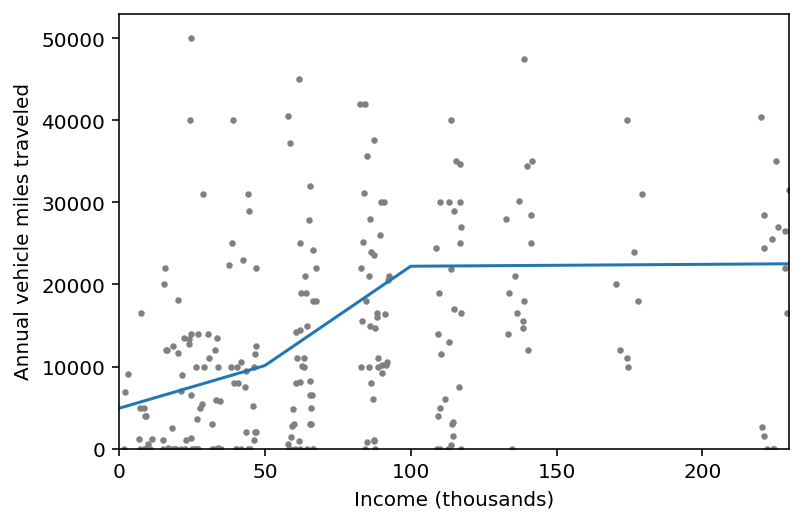

In [30]:
powdat = regdat[['income']].copy()

def piecewise(df, var, cuts):
    for left, right in zip(cuts[:-1], cuts[1:]):
        df[f'{var}_{left}-{right}'] = np.maximum(np.minimum(df[var], right) - left, 0)
        
piecewise(powdat, 'income', [0, 50, 100, np.inf])
del powdat['income']
    
powmod = sm.OLS(regdat.ANNMILES, sm.add_constant(powdat))
powfit = powmod.fit()
powfit.summary()

pdat = pd.DataFrame({'income': np.arange(0, 300, 0.25)})
piecewise(pdat, 'income', [0, 50, 100, np.inf])
    
pdat['fitted'] = powfit.predict(sm.add_constant(pdat.drop(columns=['income'])))

plt.scatter(regdat.income, regdat.ANNMILES, color='gray', s=5)
plt.plot(pdat.income, pdat.fitted)
plt.ylim(0, 53000)
plt.xlim([0, regdat.income.max()])
plt.xlabel('Income (thousands)')
plt.ylabel('Annual vehicle miles traveled')
plt.savefig('../fig/piecewise.pdf')

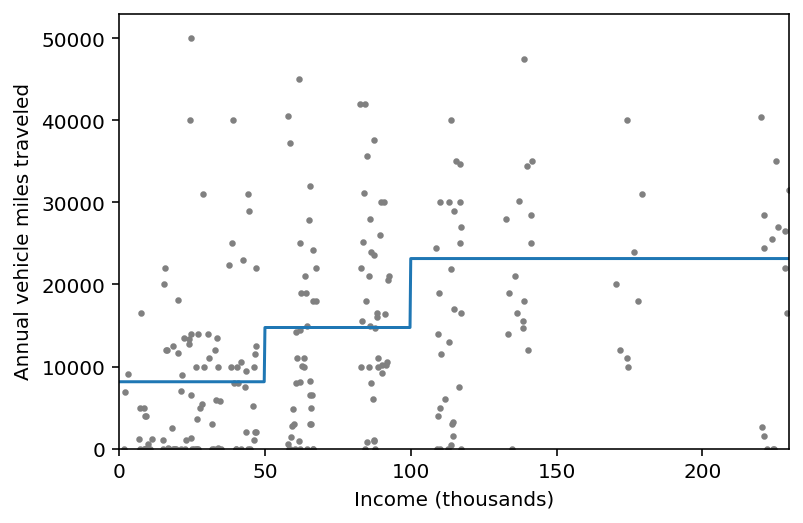

In [31]:
powdat = regdat[['income']].copy()

def piecewise(df, var, cuts):
    for left, right in list(zip(cuts[:-1], cuts[1:]))[1:]:
        df[f'{var}_{left}-{right}'] = ((df[var] >= left) & (df[var] < right)).astype('int64')
        
piecewise(powdat, 'income', [0, 50, 100, np.inf])
del powdat['income']
    
powmod = sm.OLS(regdat.ANNMILES, sm.add_constant(powdat))
powfit = powmod.fit()
powfit.summary()

pdat = pd.DataFrame({'income': np.arange(0, 300, 0.25)})
piecewise(pdat, 'income', [0, 50, 100, np.inf])
    
pdat['fitted'] = powfit.predict(sm.add_constant(pdat.drop(columns=['income'])))

plt.scatter(regdat.income, regdat.ANNMILES, color='gray', s=5)
plt.plot(pdat.income, pdat.fitted)
plt.ylim(0, 53000)
plt.xlim([0, regdat.income.max()])
plt.xlabel('Income (thousands)')
plt.ylabel('Annual vehicle miles traveled')
plt.savefig('../fig/categories.pdf')